In [62]:
vars = [var for var in globals() if var[0] != '_']
for var in vars:
    del globals()[var]

del var, vars

In [63]:
import numpy as np
import torch
import scipy.optimize as sci_opt
import sys
sys.path.append('../')
import module_opt_AD_assignment5, module_opt

import importlib
importlib.reload(module_opt_AD_assignment5)
importlib.reload(module_opt)

import matplotlib.pyplot as plt


/home/cykwonlab/NumericalOptimizationCourse25/Assignment_5/../module_opt_AD_assignment5.py:1267: SyntaxWarning: invalid escape sequence '\:'
  f (callable) : objective function(output \: single scalar)


In [64]:
start_x = 0.0
start_y = 0.0
end_x = 10.0
end_y = 10.0
N = 45

x0 = np.linspace(start_x, end_x, N)
y0 = np.linspace(start_y, end_y, N)
dv0 = np.concatenate((x0, y0))

In [65]:
len(dv0)

90

In [66]:
int(dv0.shape[0]*.5)

45

In [67]:
x = dv0[:N]
y = dv0[N:]
1/((x - 5)**2 + (y - 5)**2 + 1)

array([0.01960784, 0.02147865, 0.0236282 , 0.02611417, 0.02900983,
       0.03240927, 0.03643481, 0.04124766, 0.0470634 , 0.05417506,
       0.06298803, 0.07407407, 0.08825675, 0.10674901, 0.13137894,
       0.16496251, 0.21190893, 0.27912341, 0.37694704, 0.51820128,
       0.70760234, 0.90636704, 1.        , 0.90636704, 0.70760234,
       0.51820128, 0.37694704, 0.27912341, 0.21190893, 0.16496251,
       0.13137894, 0.10674901, 0.08825675, 0.07407407, 0.06298803,
       0.05417506, 0.0470634 , 0.04124766, 0.03643481, 0.03240927,
       0.02900983, 0.02611417, 0.0236282 , 0.02147865, 0.01960784])

In [68]:
sum(1/((x - 5)**2 + (y - 5)**2 + 1))

np.float64(8.919456477298413)

In [69]:
np.arange(N-1).sum()

np.int64(946)

In [70]:
np.array([(x0[i+1] - x0[i])**2 + (y0[i+1] - y0[i])**2 for i in np.arange(N-1)]).sum()

np.float64(4.545454545454547)

In [71]:
N = 45 # The number of positions of drone
T = 15.0 # Total flight time [sec]
vmax = 1.5 # Maximum velocity [unit / sec]

def f(dv):
    N = int(dv.shape[0]*.5)
    x = dv[:N]
    y = dv[N:]
    C = (1/((x - 5)**2 + (y - 5)**2 + 1)).sum()
    d_sq = np.array([(x[i+1] - x[i])**2 + (y[i+1] - y[i])**2 for i in np.arange(N-1)]).sum()
    return C + d_sq

def ce1(dv): # x1 = 0.0
    return dv[0]

def ce2(dv): # y1 = 0.0
    N = int(dv.shape[0]*.5)
    return dv[N]

def ce3(dv): # xN = 10.0
    N = int(dv.shape[0]*.5)
    return dv[N-1] - 10.0

def ce4(dv): # yN = 10.0
    return dv[-1] - 10.0

def ce5(dv): # (x2 - x1)/(15/(N - 1)) = 0.0 <-> u1 = 0.0
    N = int(dv.shape[0]*.5)
    return (dv[1] - dv[0])/(T/(N - 1))

def ce6(dv): # (y2 - y1)/(15/(N - 1)) = 0.0 <-> v1 = 0.0
    N = int(dv.shape[0]*.5)
    return (dv[N+1] - dv[N])/(T/(N - 1))

ci_x_larger_0 = [lambda dv, i=i : dv[i] for i in np.arange(N)] # xi >= 0.0
ci_x_smaller_10 = [lambda dv, i=i : -dv[i] + 10.0 for i in np.arange(N)] # xi <= 10.0
ci_y_larger_0 = [lambda dv, i=i : dv[N+i] for i in np.arange(N)] # yi >= 0.0
ci_y_smaller_10 = [lambda dv, i=i : -dv[N+i] + 10.0 for i in np.arange(N)] # yi <= 10.0
ci_v_smaller_vmax = [lambda dv, i=i : vmax**2 - (((dv[i+1] - dv[i])/(T/(N - 1)))**2 + ((dv[N+i+1] - dv[N+i])/(T/(N - 1)))**2) for i in np.arange(N-1)] # vi^2 <= vmax^2

In [72]:
# 기존 파라미터 (그대로 사용)
N = 45  # The number of positions of drone
T = 15.0  # Total flight time [sec]
vmax = 1.5  # Maximum velocity [unit / sec]

# -----------------------------
# 1. 목적함수 f(dv) 의 torch 버전
# -----------------------------
def f_torch(dv: torch.Tensor) -> torch.Tensor:
    # dv shape: (2N,)
    N_local = dv.shape[0] // 2
    x = dv[:N_local]
    y = dv[N_local:]
    C = (1.0 / ((x - 5.0) ** 2 + (y - 5.0) ** 2 + 1.0)).sum()
    d_sq = (((x[1:] - x[:-1]) ** 2) + ((y[1:] - y[:-1]) ** 2)).sum()
    return C + d_sq

# -----------------------------
# 2. Equality constraints (ce1 ~ ce6) 의 torch 버전
# -----------------------------

def ce1_torch(dv: torch.Tensor) -> torch.Tensor:
    # x1 = 0.0
    return dv[0]

def ce2_torch(dv: torch.Tensor) -> torch.Tensor:
    # y1 = 0.0
    N_local = dv.shape[0] // 2
    return dv[N_local]

def ce3_torch(dv: torch.Tensor) -> torch.Tensor:
    # xN = 10.0
    N_local = dv.shape[0] // 2
    return dv[N_local - 1] - 10.0

def ce4_torch(dv: torch.Tensor) -> torch.Tensor:
    # yN = 10.0
    return dv[-1] - 10.0

def ce5_torch(dv: torch.Tensor) -> torch.Tensor:
    # (x2 - x1)/(T/(N-1)) = 0.0  <-> u1 = 0.0
    N_local = dv.shape[0] // 2
    dt = T / (N_local - 1)
    return (dv[1] - dv[0]) / dt

def ce6_torch(dv: torch.Tensor) -> torch.Tensor:
    # (y2 - y1)/(T/(N-1)) = 0.0  <-> v1 = 0.0
    N_local = dv.shape[0] // 2
    dt = T / (N_local - 1)
    return (dv[N_local + 1] - dv[N_local]) / dt

# -----------------------------
# 3. Inequality constraints 의 torch 버전 (리스트들)
#    - xi >= 0.0
#    - xi <= 10.0
#    - yi >= 0.0
#    - yi <= 10.0
#    - vi^2 <= vmax^2
# -----------------------------

# xi >= 0.0
ci_x_larger_0_torch = [
    (lambda dv, i=i: dv[i]) for i in range(N)
]

# xi <= 10.0  <->  -xi + 10 >= 0
ci_x_smaller_10_torch = [
    (lambda dv, i=i: -dv[i] + 10.0) for i in range(N)
]

# yi >= 0.0
ci_y_larger_0_torch = [
    (lambda dv, i=i: dv[N + i]) for i in range(N)
]

# yi <= 10.0  <->  -yi + 10 >= 0
ci_y_smaller_10_torch = [
    (lambda dv, i=i: -dv[N + i] + 10.0) for i in range(N)
]

# vi^2 <= vmax^2  <->  vmax^2 - vi^2 >= 0
# vi^2 = ((x_{i+1}-x_i)/dt)^2 + ((y_{i+1}-y_i)/dt)^2
ci_v_smaller_vmax_torch = []
for i in range(N - 1):
    def ci_vi_torch(dv: torch.Tensor, i=i) -> torch.Tensor:
        dt = T / (N - 1)
        x_i = dv[i]
        x_ip1 = dv[i + 1]
        y_i = dv[N + i]
        y_ip1 = dv[N + i + 1]
        vx_i = (x_ip1 - x_i) / dt
        vy_i = (y_ip1 - y_i) / dt
        vi_sq = vx_i**2 + vy_i**2
        return vmax**2 - vi_sq
    ci_v_smaller_vmax_torch.append(ci_vi_torch)

In [73]:
# Create linear dv0
start_x = 0.0
start_y = 0.0
end_x = 10.0
end_y = 10.0
N = 45

x0 = np.linspace(start_x, end_x, N)
y0 = np.linspace(start_y, end_y, N)
dv0 = np.concatenate((x0, y0))

In [74]:
# Test if f, ce work well
  
print(f(dv0))
print(ce1(dv0))
print(ce2(dv0))
print(ce3(dv0))
print(ce4(dv0))
print(ce5(dv0))
print(ce6(dv0))

13.46491102275296
0.0
0.0
0.0
0.0
0.6666666666666667
0.6666666666666667


In [75]:
# Test if ci works well

for ci in ci_x_larger_0:
# for ci in ci_x_smaller_10:
# for ci in ci_y_larger_0:
# for ci in ci_y_smaller_10:
# for ci in ci_v_smaller_vmax:
    print(ci(dv0))

0.0
0.22727272727272727
0.45454545454545453
0.6818181818181818
0.9090909090909091
1.1363636363636362
1.3636363636363635
1.5909090909090908
1.8181818181818181
2.0454545454545454
2.2727272727272725
2.5
2.727272727272727
2.9545454545454546
3.1818181818181817
3.409090909090909
3.6363636363636362
3.8636363636363633
4.090909090909091
4.318181818181818
4.545454545454545
4.7727272727272725
5.0
5.2272727272727275
5.454545454545454
5.681818181818182
5.909090909090909
6.136363636363636
6.363636363636363
6.590909090909091
6.818181818181818
7.045454545454545
7.2727272727272725
7.5
7.727272727272727
7.954545454545454
8.181818181818182
8.409090909090908
8.636363636363637
8.863636363636363
9.09090909090909
9.318181818181818
9.545454545454545
9.772727272727272
10.0


QP 부문제가 feasible한데도 불구하고 alm4sqp가 QP 부문제의 해를 찾지 못함  
1. ∇L_A이 감소하지 않고 커짐
2. 제약함수(ce_QPk, ci_QPk)의 값이 0을 만족하지 못함
3. 제약함수 값이 어느 정도 작아진 상태에서도 목적함수(Q_QPk) 값이 줄지 않고 계속 늘어남  

결국 alm4sqp가 QP 부문제를 잘 풀지 못한다는 얘기. 왜인지는 모르겠음.

In [76]:
ci = ci_x_larger_0 + ci_x_smaller_10 + ci_y_larger_0 + ci_y_smaller_10 + ci_v_smaller_vmax
ci_torch = ci_x_larger_0_torch + ci_x_smaller_10_torch + ci_y_larger_0_torch + ci_y_smaller_10_torch + ci_v_smaller_vmax_torch
log_opt_AD_sqp = module_opt_AD_assignment5.sqp(f=f, f_torch=f_torch, ce=[ce1, ce2, ce3, ce4, ce5, ce6], ce_torch=[ce1_torch, ce2_torch, ce3_torch, ce4_torch, ce5_torch, ce6_torch], ci=ci, ci_torch=ci_torch, x0=dv0, inner_opt=3, tol=1e-6, tol_inter=1e-3)

Phase I LP success      : True
Phase I LP status       : Optimization terminated successfully. (HiGHS Status 7: Optimal)
Phase I LP rho*         : 0.0
QP (linearized) feasible?: YES

 log - ALM
‖∆p‖ = 1.57e+00, p01 = [0.22399420, -0.00350333, -0.00507720, -0.00589168, -0.00688805, -0.00811934, -0.00965798, -0.01160442, -0.01410029, -0.01734905, -0.02164864, -0.02744471, -0.03541843, -0.04663411, -0.06278775, -0.08661677, -0.12251330, -0.17713158, -0.25843666, -0.36631245, -0.45533077, -0.30403203, -0.00000000, 0.30403203, 0.45533077, 0.36631245, 0.25843666, 0.17713158, 0.12251330, 0.08661677, 0.06278775, 0.04663411, 0.03541843, 0.02744471, 0.02164864, 0.01734905, 0.01410029, 0.01160442, 0.00965798, 0.00811934, 0.00688805, 0.00589168, 0.00507720, 0.00440521, -0.22490212, 0.22399420, -0.00350333, -0.00507720, -0.00589168, -0.00688805, -0.00811934, -0.00965798, -0.01160442, -0.01410029, -0.01734905, -0.02164864, -0.02744471, -0.03541843, -0.04663411, -0.06278775, -0.08661677, -0.12251330,

In [399]:
ci = ci_x_larger_0 + ci_x_smaller_10 + ci_y_larger_0 + ci_y_smaller_10 + ci_v_smaller_vmax
ci_torch = ci_x_larger_0_torch + ci_x_smaller_10_torch + ci_y_larger_0_torch + ci_y_smaller_10_torch + ci_v_smaller_vmax_torch
log_opt_AD_alm = module_opt_AD_assignment5.alm(f=f, f_torch=f_torch, ce=[ce1, ce2, ce3, ce4, ce5, ce6], ce_torch=[ce1_torch, ce2_torch, ce3_torch, ce4_torch, ce5_torch, ce6_torch], ci=ci, ci_torch=ci_torch, x0=dv0, inner_opt=3, tol=1e-4)

mu_0 = 1
rho_0 = 1
tau_0 = 0.01
1-th outer loop : Inner loop converges at 34 iteration(s) ...
|x_1 - x_0| = 4.1907654988487515
Max violation of equality constraints : 0.27778298712371363
Max violation of inequality constraints : 0.14619971601247528

------------------------------------------------------------- Outer loop ----------------------------------------------------------------

mu_1 = 5.0
rho_1 = 5.0
tau_1 = 0.005
2-th outer loop : Inner loop converges at 142 iteration(s) ...
|x_2 - x_1| = 14.025773469024765
Max violation of equality constraints : 0.07136211012280569
Max violation of inequality constraints : 0.016255491943113043

------------------------------------------------------------- Outer loop ----------------------------------------------------------------

mu_2 = 25.0
rho_2 = 25.0
tau_2 = 0.0025
3-th outer loop : Inner loop converges at 39 iteration(s) ...
|x_3 - x_2| = 0.3655972469859991
Max violation of equality constraints : 0.0003115327905615821
Max violation of i

In [379]:
# 1) equality constraints
eq_constraints = [
    {'type': 'eq', 'fun': ce1},
    {'type': 'eq', 'fun': ce2},
    {'type': 'eq', 'fun': ce3},
    {'type': 'eq', 'fun': ce4},
    {'type': 'eq', 'fun': ce5},
    {'type': 'eq', 'fun': ce6},
]

# 2) inequality constraints (리스트 안에 있는 각각의 lambda를 감싸주기)
ineq_constraints = []

for c in ci_x_larger_0:
    ineq_constraints.append({'type': 'ineq', 'fun': c})

for c in ci_x_smaller_10:
    ineq_constraints.append({'type': 'ineq', 'fun': c})

for c in ci_y_larger_0:
    ineq_constraints.append({'type': 'ineq', 'fun': c})

for c in ci_y_smaller_10:
    ineq_constraints.append({'type': 'ineq', 'fun': c})

for c in ci_v_smaller_vmax:
    ineq_constraints.append({'type': 'ineq', 'fun': c})

# 3) 모두 합치기
constraints = eq_constraints + ineq_constraints

In [380]:
# ------------------------------------------------------------------ xk Log of SLSQP ------------------------------------------------------------------
x_slsqp = []
def cb(xk):
    x_slsqp.append(xk.copy())

In [381]:
# 단순히 (0,0)에서 (10,10)로 직선 경로를 초기값으로 두는 예시
x0 = np.linspace(0.0, 10.0, N)
y0 = np.linspace(0.0, 10.0, N)
dv0 = np.concatenate([x0, y0])

x_slsqp.append(dv0)
res = sci_opt.minimize(
    fun=f,
    x0=dv0,
    method='SLSQP',          # constraint 다루기 좋으니까
    constraints=constraints,
    options={'ftol': 1e-8, 'maxiter': 1000, 'disp': True},
    callback=cb
)

print("success:", res.success)
print("message:", res.message)
print("f_min:", res.fun)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 8.097717205241308
            Iterations: 87
            Function evaluations: 7978
            Gradient evaluations: 87
success: True
message: Optimization terminated successfully
f_min: 8.097717205241308


In [419]:
def plot_slsqp_paths(x_slsqp, N):
    plt.figure(figsize=(6,6))

    # 이전 경로일수록 더 연하게 (alpha 점점 증가)
    # K = len(x_slsqp)   # iteration 개수
    K = 3

    for k, dv in enumerate(x_slsqp):
        dv = np.array(dv)
        x = dv[:N]
        y = dv[N:]

        # alpha: 초기에는 매우 투명 → 후반에는 진하게
        alpha = 0.1 + 0.9 * (k / (K - 1))
        
        plt.plot(x, y, color='blue', alpha=alpha)

    # 시작점, 끝점 강조
    plt.scatter([0], [0], color='green', s=80, label='Start (0,0)')
    plt.scatter([10], [10], color='red', s=80, label='Goal (10,10)')

    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("SLSQP Iteration Paths")
    plt.grid(True)
    plt.legend()
    plt.axis('equal')
    plt.show()

ValueError: alpha (1.4500000000000002) is outside 0-1 range

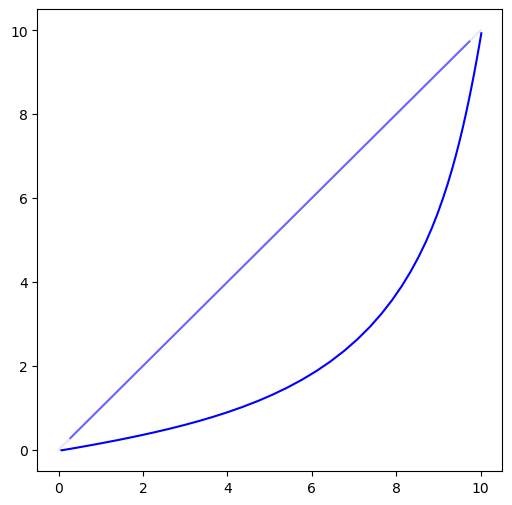

In [420]:
plot_slsqp_paths(log_opt_AD_alm[0], 45)

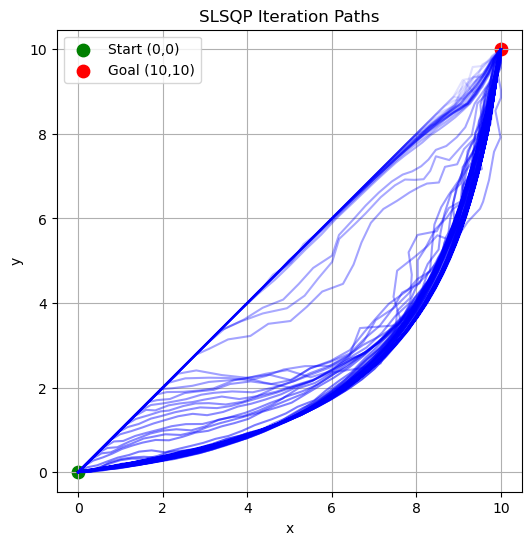

In [406]:
plot_slsqp_paths(x_slsqp, 45)

In [359]:
x_opt = res.x[:45]
y_opt = res.x[45:]